<a href="https://colab.research.google.com/github/kimisuke0503/colab-research/blob/main/movieLens_average/ave_mobie_2d_visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

movieLens_average/ave_mobie_2d_visualization.ipynb

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
import sys
import random
import csv
from sklearn.metrics import roc_auc_score

np.set_printoptions(suppress=True)

# データインポート

In [9]:
data_training = pd.read_excel('data_training.xlsx',index_col=0)
data_training = data_training.drop('user_id', axis=1)
display(data_training)
data_test = pd.read_excel('data_test.xlsx',index_col=0)

X = data_training.values
TEST = data_test.values

print(X.shape)
print(TEST.shape)

,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
0,5,3,4,3,3,5,4,1,5,3,...,0,0,0,0,0,0,0,0,0,0
1,4,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
938,0,0,0,0,0,0,0,0,5,0,...,0,0,0,0,0,0,0,0,0,0
939,0,0,0,0,0,0,4,5,3,0,...,0,0,0,0,0,0,0,0,0,0
940,5,0,0,0,0,0,4,0,0,0,...,0,0,0,0,0,0,0,0,0,0
941,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


(943, 1682)
(10000, 3)


In [10]:
# 未評価値を各ユーザーの平均評価値で補完
ave = np.empty((X.shape[0]))
for n in range(X.shape[0]):
    n_sum = 0
    for m in range(X.shape[1]):
        n_sum += X[n][m]
    if n_sum == 0:
        ave[n] = 0
    else:
        ave[n] = n_sum/np.count_nonzero(X,axis=1)[n]

X_movie = np.asarray(X, dtype = "float")

for n in range(X.shape[0]):
  for m in range(X.shape[1]):
    if X[n][m] == 0 :
      X_movie[n][m] = ave[n]

print(X_movie)

[[5.         3.         4.         ... 3.61065574 3.61065574 3.61065574]
 [4.         3.75438596 3.75438596 ... 3.75438596 3.75438596 3.75438596]
 [2.80392157 2.80392157 2.80392157 ... 2.80392157 2.80392157 2.80392157]
 ...
 [5.         4.04761905 4.04761905 ... 4.04761905 4.04761905 4.04761905]
 [4.27027027 4.27027027 4.27027027 ... 4.27027027 4.27027027 4.27027027]
 [3.42361111 5.         3.42361111 ... 3.42361111 3.42361111 3.42361111]]


# 主成分分析

,PC1,PC2
0,-0.898901,5.456900
1,-6.878961,-0.579917
2,32.070589,-1.444466
3,-31.868774,-0.902860
4,31.980656,2.542501
...,...,...
938,-27.678984,-0.519917
939,6.806296,-0.509522
940,-18.916347,-0.801076
941,-28.050082,-0.117243


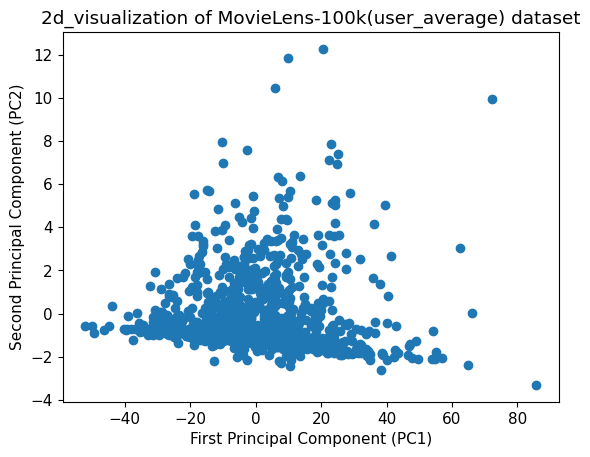

<Figure size 640x480 with 0 Axes>

In [16]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_movie)
pca_result_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
display(pca_result_df)

plt.scatter(x='PC1', y='PC2', data=pca_result_df)
plt.title("2d_visualization of MovieLens-100k(user_average) dataset")
plt.rcParams["font.size"] = 11
plt.xlabel('First Principal Component (PC1)')
plt.ylabel('Second Principal Component (PC2)')
plt.show()
plt.savefig(f"user_average_movie_2d_visualization.png", format="png", dpi=300)

In [22]:
# 主成分考察

# 主成分1

# print('PC1の固有ベクトル\n', pca.components_[0])

# PC1に基づいてトップ10とボトム10のインデックスを取得
pc1_top_10_indices = pca_result_df.nlargest(10, 'PC1').index
pc1_bottom_10_indices = pca_result_df.nsmallest(10, 'PC1').index

# 元のベクトルを抽出
X_movie_df = pd.DataFrame(X_movie)
pc1_top_10_original_vectors = X_movie_df.iloc[pc1_top_10_indices]
pc1_bottom_10_original_vectors = X_movie_df.iloc[pc1_bottom_10_indices]

# 元のベクトルを表示
print("top10:" )
print("平均評価値", np.average(pc1_top_10_original_vectors.values, axis=1))
# print("未評価値の数", np.count_nonzero(pc1_top_10_original_vectors.values, axis=1))
# display(pc1_top_10_original_vectors)
print("bottom10: ")
# display(pc1_bottom_10_original_vectors)
print("平均評価値", np.average(pc1_bottom_10_original_vectors.values, axis=1))
# print("未評価値の数", np.count_nonzero(pc1_bottom_10_original_vectors.values, axis=1))

top10:
平均評価値 [1.49869452 1.83534743 1.97413793 2.         2.06763285 2.2
 2.24137931 2.25       2.26666667 2.26923077]
未評価値の数 [1682 1682 1682 1682 1682 1682 1682 1682 1682 1682]
bottom10: 
平均評価値 [4.85714286 4.80952381 4.79166667 4.71698113 4.67741935 4.66153846
 4.5648855  4.55172414 4.5483871  4.53846154]
未評価値の数 [1682 1682 1682 1682 1682 1682 1682 1682 1682 1682]


In [24]:
# 主成分2

# print('PC2の固有ベクトル\n', pca.components_[1])

# PC2に基づいてトップ10とボトム10のインデックスを取得
pc2_top_10_indices = pca_result_df.nlargest(10, 'PC2').index
pc2_bottom_10_indices = pca_result_df.nsmallest(10, 'PC2').index

# 元のベクトルを抽出
X_movie_df = pd.DataFrame(X_movie)
pc2_top_10_original_vectors = X_movie_df.iloc[pc2_top_10_indices]
pc2_bottom_10_original_vectors = X_movie_df.iloc[pc2_bottom_10_indices]

pc2_top_10_original_vectors_ = data_training.iloc[pc2_top_10_indices]
pc2_bottom_10_original_vectors_ = data_training.iloc[pc2_bottom_10_indices]

# 元のベクトルを表示
print("top10:" )
print("平均評価値", np.average(pc2_top_10_original_vectors.values, axis=1))
print("評価値の数", np.count_nonzero(pc2_top_10_original_vectors_.values, axis=1))
# display(pc2_top_10_original_vectors)
print("bottom10: ")
# display(pc2_bottom_10_original_vectors)
print("平均評価値", np.average(pc2_bottom_10_original_vectors.values, axis=1))
print("評価値の数", np.count_nonzero(pc2_bottom_10_original_vectors_.values, axis=1))

top10:
平均評価値 [3.08931699 3.35103926 3.44924406 1.83534743 3.84307692 3.02915452
 3.6557377  2.97568389 3.04322767 3.83632287]
評価値の数 [571 433 463 662 325 343 366 329 347 446]
bottom10: 
平均評価値 [1.49869452 2.65168539 3.33333333 2.         3.4        3.89552239
 3.41237113 3.65       3.32608696 2.73684211]
評価値の数 [383  89  66  19 100 134  97  40  92  19]


In [ ]:
def RSCCMM(X, C, delta):
  n, m = X.shape
  u = np.zeros((C,n))
  normalized_u = np.zeros((C,n))

  #要素の正規化
  #sys.float_info.epsilon を足してないと、類似度計算の時にlog(0)となってNaNが発生する
  # X = X + sys.float_info.epsilon
  # np.where(X == 0, sys.float_info.epsilon, X)
  normalized_X = X / np.sum(X, 1)[:, np.newaxis]

  #類似度
  s_it = np.array([np.sum(normalized_X * np.log(row + sys.float_info.epsilon), 1) for row in normalized_X])

  #二項関係
  #deltaの値が小さすぎると二項関係がなくなって、(※)式のところでゼロ徐算が発生する
  R = (s_it >= delta).astype(np.float64)

  #初期項目メンバシップ
  w = np.array([X[c] + sys.float_info.epsilon for c in random.sample(range(n), C)])
  w /= w.sum(1)[:,np.newaxis]

  #繰り返し処理
  for i in range(100):
    old_u = normalized_u.copy()
    u = np.zeros((C,n))
    normalized_u = np.zeros((C,n))

    #HCCMM的なクラスター割り当てによるメンバシップ
    s = np.log(w) @ X.T
    s_max = np.max(s, 0)
    u = (s >= s_max).astype(np.float64)

    #粒状性（二項関係）を考慮した上近似メンバシップ
    if(np.any(np.sum(R, 1) == 0)):
       raise Exception("二項関係がない")
    normalized_u = ((u @ R.T) / np.sum(R, 1) > 0).astype(np.float64) #(※)
    normalized_u /= normalized_u.sum(0)

    #正規化メンバシップ更新
    #ここでも微小値を足していないと次の類似度計算の時にNaNになって計算できなくなる
    w = (normalized_u @ X) + sys.float_info.epsilon
    if(np.any(np.isnan(w.sum(1)))):
      raise Exception("NaN発生")
    w /= w.sum(1)[:, np.newaxis]

    if np.abs(normalized_u - old_u).max() == 0:
      break

  return normalized_u.T @ w, (u @ R.T) / np.sum(R, 1)

In [ ]:
#roopの回数を指定し、最大のaucとその時のクラスター構造を返す関数(RSCCMM)
from sklearn.metrics import roc_auc_score

def RSCCMM_CF_AUC_CLUSTER(roop, test, X, C, delta):
  n, m = X.shape
  test_num, test_num_fact = test.shape
  auc_max = 0
  rm_max = 0

  test_true = np.zeros(test_num)
  r_test_score = np.zeros(test_num)

  for i in range(test_num):
    test_true[i] = 1 if test[i][2] > 3 else 0

  for i in range(roop):
    r, rm = RSCCMM(X, C, delta) # RSCCM法を適用

    for j in range(test_num):
      r_test_score[j] = r[test[j][0]-1][test[j][1]-1]

    auc = roc_auc_score(test_true, r_test_score) # AUCを計算

    if auc > auc_max:
      auc_max = auc
      rm_max = rm


  return auc_max, rm_max

auc, rm = RSCCMM_CF_AUC_CLUSTER(10, TEST, X_movie, 3, -7.430)
print("auc: ", auc)

auc:  0.7072713047552386


auc_max:  0.7091151328700238
delta_max:  -7.430000000000001


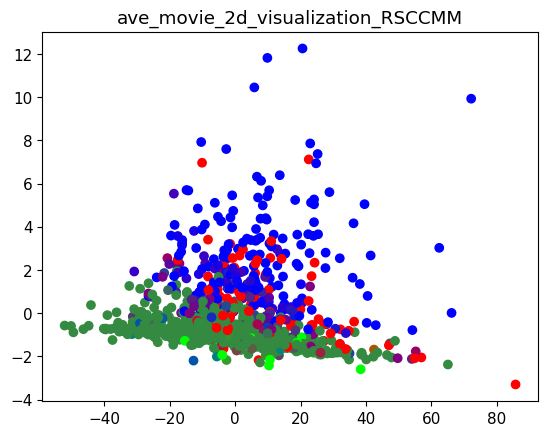

In [ ]:
name = "ave_movie_2d_visualization_RSCCMM"
C = 3
loop = 10
delta_list = np.arange(-7.428, -7.432, -0.001)

auc_max = 0
rm_max = 0
delta_max = 0
for delta in delta_list:
  auc, rm = RSCCMM_CF_AUC_CLUSTER(10, TEST, X_movie, C, delta)
  if auc > auc_max:
    auc_max = auc
    rm_max = rm
    delta_max = delta


print("auc_max: ", auc_max)
print("delta_max: ", delta_max)

# PCA
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

N_DIMENSIONS = 2

pca = PCA(N_DIMENSIONS) # 次元数を設定して初期化
printcipalComponents = pca.fit_transform(X_movie)
principalDf = pd.DataFrame(data=printcipalComponents, columns = ['principal component1', 'principal component2'])
principalValue = principalDf.values # 主成分データ


plt.scatter(principalValue[:,0], principalValue[:,1], color=rm_max.T)
plt.title(name)
plt.rcParams["font.size"] = 11
plt.savefig(f"{name}.png", format="png", dpi=300)

with open(f'{name}_rough_membership.csv', 'wt', encoding='utf-8', newline='') as fout:
    writer = csv.writer(fout)
    writer.writerows(rm_max)

output_info = [["auc", "delta"]]
output_info.append([auc_max, delta_max])
with open(f'{name}_info.csv', 'wt', encoding='utf-8', newline='') as fout:
    writer = csv.writer(fout)
    writer.writerows(output_info)